## Import packages

In [1]:
# read nc output from WAOM 10km run

from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import xarray as xr
import pandas as pd
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import matplotlib.path as mpath

from datetime import datetime, timedelta
import math

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps


from shapely.ops import cascaded_union
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# for gsw
import sys
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
import gsw

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.feature as cfeature
#from xgcm import Grid

In [2]:
from xgcm import Grid
import warnings
warnings.filterwarnings('ignore')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Set up the datasets

In [4]:
ds1  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc")
ds2  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0002.nc")
ds3  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0003.nc")
ds4  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0004.nc")
ds5  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0005.nc")
ds6  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0006.nc")
ds7  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0007.nc")
ds8  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0008.nc")
ds9  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0009.nc")
ds10 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0010.nc")
ds11 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0011.nc")
ds12 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0012.nc")

In [5]:
idx = 0
dg = xr.open_dataset("/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc")
lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]

dens1 = np.zeros((4,31,560,630))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(idx)
    
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]

    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    #print(Zo_rho.shape)
    #print(ds.zeta.shape,ds.h.shape,ds.zice.shape)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
    
    #print(z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho").shape)
    ds.coords['z_rho'] = z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho")

    # read grid file for lon/lat coordinates
    ds.coords['lat_rho']=lat_rho#.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho#.transpose() # put lon_rho into ds dataset
    
    p = p = gsw.p_from_z(z=z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho"),lat=-66.8245)

    
    #dens1 = dens1 + gsw.rho(salt,temp,1000)-1000
    dens1 = dens1 + gsw.rho(salt,temp,p)-1000
    idx += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [6]:
def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(0,-63.8,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-60,-55,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-120,-54.7,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(180,-62,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return

proj = ccrs.SouthPolarStereo()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)

bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

In [7]:
# Handle interpolation from u and v grid to rho points:
# loop through the datasets and do the averaging
i = 0

for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(i)

    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [8]:
# call cartopy projectione
proj = ccrs.SouthPolarStereo()

# re-gridding
src = ccrs.SouthPolarStereo()
nx, ny = 630, 560

In [9]:
fig_path='/scratch/project_2000789/muramarg/reviews1/'

In [19]:
# find the dlon at 60S
L= (2*np.pi*6371*1000*np.cos(-60 * np.pi/180))/360

(array([  0,   0,   0, ..., 559, 559, 559]),
 array([151, 152, 153, ..., 508, 509, 510]))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


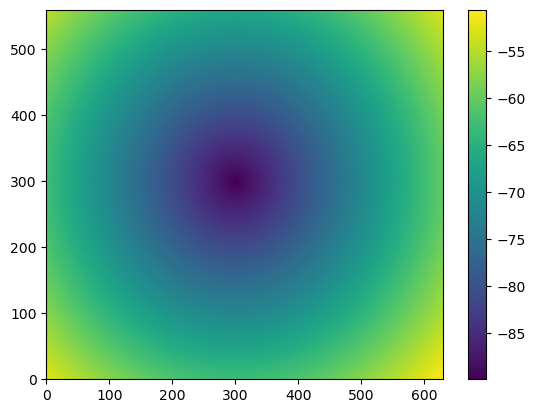

In [84]:
plt.pcolormesh(lat_rho)
plt.colorbar()
target_lat = -60
tolerance = 0.1
indices = np.where((lat_rho >= target_lat - tolerance) & (lat_rho <= target_lat + tolerance))
indices

In [85]:
def calculate_streamfunction_60(mer_speed, dlon, rho, dz, rhobins):
    """
    Calculate stream function Ψ(z) from ROMS velocity components
        
    Returns:
        stream_function (numpy.ndarray): Stream function values at each density.
    """
    stream_function = np.zeros(rhobins.shape)
    volume = mer_speed * dz * dlon
    bin_i = np.digitize(rho,rhobins) - 1
    masked_volume = np.ma.masked_invalid(volume)
    masked_bin_i = np.ma.masked_where(masked_volume.mask, bin_i)
    stream_function += np.bincount(masked_bin_i.compressed(), weights=masked_volume.compressed() / 1e6, minlength=len(rhobins))
    return volume,masked_bin_i,stream_function

### Let's try to do this with all the datasets

In [86]:
rhobins = np.linspace(23.9, 28+0.2, 168)

(4, 31, 560, 630)


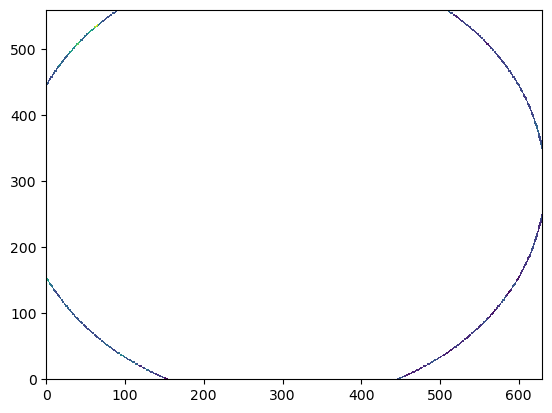

In [87]:
test = np.array(ds1.v.values)
test = np.pad(test, ((0,0),(0, 0), (1, 0), (0, 0)), mode='constant', constant_values=0)
mask = np.ones((4, 31, 560, 630), dtype=bool)
print(mask.shape)

# Assuming 'indices' contains the indices where lat_rho is within -60 ± 0.1
# Fill the mask array with False at the specified indices
mask[:,:,indices[0],indices[1]] = False

# Fill the dataset with NaNs where the mask is True
test[mask] = np.nan
test = np.mean(test,axis=0)
test = np.mean(test,axis=0)
plt.pcolormesh(test)

In [88]:
idx = 0
long = 73.5089
lat = -66.8245
streams = np.zeros((48,rhobins.shape[0]))
#for ds in ,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print("set",idx)
    
    #### get salt and temp
    dens1 = np.zeros((4,31,560,630))
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]
    z = ds.coords['z_rho'][0][0]
    p = gsw.p_from_z(z,lat)
    SA = gsw.SA_from_SP(np.array(salt),np.array(p),long,lat)
    CT = gsw.CT_from_pt(SA,np.array(temp))
    dens1 = dens1 + gsw.rho(SA,CT,0)-1000           # this might need to change
    dens1 = (dens1[:,1:,:,:] + dens1[:,:-1,:,:])/2      # average so we can multiply by dz
    
    #print(np.nanmax(dens1),np.nanmin(dens1))
    
    ### get the meridional speed
    mer_speed = np.array(ds.v.values)
    mer_speed = np.pad(mer_speed, ((0,0),(0, 0), (1, 0), (0, 0)),mode='constant', constant_values=0)
    mask = np.ones((4, 31, 560, 630), dtype=bool)
    mask[:,:,indices[0],indices[1]] = False
    mer_speed[mask] = np.nan    # only select those on the -65 degree line
    mer_speed = (mer_speed[:,1:,:,:] + mer_speed[:,:-1,:,:])/2
    
    
    ### now we can do the streamfunction!
    for i in range(mer_speed.shape[0]):
        
        ### dz will be the same every time
        dz = np.abs(np.diff(ds.z_rho[i],axis=0))
        
        #print(dz.shape)
        #dz = np.pad(dz, ((0,0),(0, 0), (1, 0), (0, 0)),mode='constant', constant_values=0)
        #print(mer_speed[i].shape,dz.shape)

    
        volume,bin_i,stream_function = calculate_streamfunction_60(mer_speed[i], L, dens1[i], dz, rhobins)
        streams[idx] = stream_function
        idx += 1

set 0
set 4
set 8
set 12
set 16
set 20
set 24
set 28
set 32
set 36
set 40
set 44


Text(0, 0.5, 'Density (kg/m^3) - 1000')

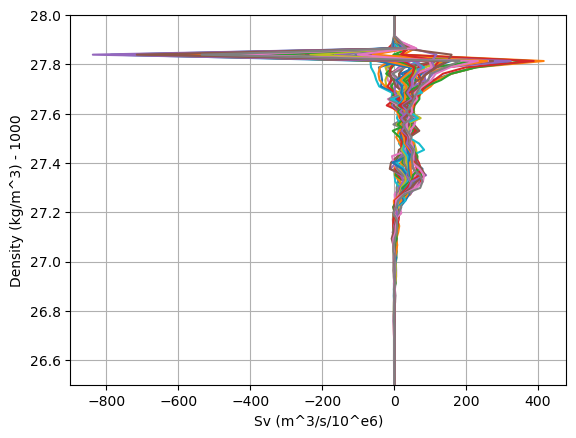

In [89]:
##### fig = plt.figure()
for i in range(48):
    plt.plot(streams[i],rhobins,label=i)
plt.ylim([26.5,28])
# plt.legend(loc="best")
plt.grid()
plt.xlabel("Sv (m^3/s/10^e6)")
plt.ylabel("Density (kg/m^3) - 1000")

Text(0, 0.5, 'Density (kg/m^3) - 1000')

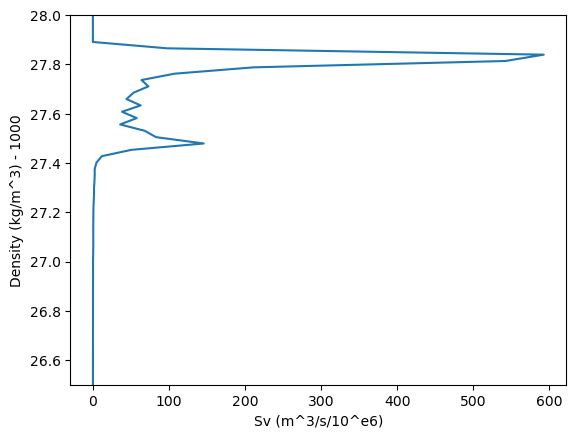

In [67]:
stream_mean = np.mean(streams,axis=0)
fig = plt.figure()
plt.plot(stream_mean,rhobins)
plt.ylim([26.5,28])
plt.xlabel("Sv (m^3/s/10^e6)")
plt.ylabel("Density (kg/m^3) - 1000")

In [81]:
print(rhobins[-16:])
streamsa = streams[:,-16:]
streamsa.shape

[27.81377246 27.83952096 27.86526946 27.89101796 27.91676647 27.94251497
 27.96826347 27.99401198 28.01976048 28.04550898 28.07125749 28.09700599
 28.12275449 28.14850299 28.1742515  28.2       ]


(48, 16)

In [83]:
mask = streamsa < 0

# Apply the mask to your array and calculate the sum
sum_less_than_zero = np.sum(streamsa[mask])

print("Sum of elements less than 0:", sum_less_than_zero/4)

Sum of elements less than 0: -23.131118313571598
